In [3]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn import preprocessing
from scipy import stats
from itertools import combinations

from news_vec.utils import read_json_gz_lines

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [5]:
df = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-ab-rows.json/'))))

1278944it [00:19, 64013.99it/s]


In [6]:
d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))

In [7]:
df.drop(['d1', 'd2'], 1)
df['d1'] = d1s
df['d2'] = d2s

In [8]:
df['p_false'] = 1 - df.p_true

In [9]:
df['log_imp'] = np.log(df.impressions)

In [17]:
def sl_imp_corr(d1, d2, plot=False, height=5):
    
    d1s, d2s = sorted([d1, d2])
    
    pdf = df[(df.d1==d1s)&(df.d2==d2s)&(df.domain==d1)].copy()
    pdf['log_imp_scaled'] = preprocessing.scale(pdf.log_imp)
    
    if plot:

        sns.jointplot(
            y='log_imp_scaled',
            x='p_false',
            data=pdf,
            kind='reg',
            scatter_kws=dict(s=1),
            height=height,
        )

        plt.show()
    
    return stats.kendalltau(pdf.p_false, pdf.log_imp_scaled), pdf

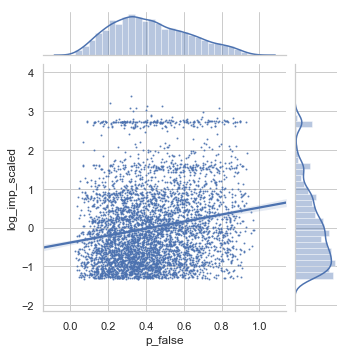

In [18]:
kt, _ = sl_imp_corr('huffingtonpost.com', 'dailykos.com', True)

In [19]:
kt

KendalltauResult(correlation=0.12188969194733597, pvalue=7.303523892645293e-36)

In [20]:
domains = df.domain.unique()

In [21]:
pairs = list(combinations(domains, 2))

In [22]:
rows = []
for d1, d2 in tqdm(pairs):

    kt, pdf = sl_imp_corr(d1, d2)
    rows.append((d1, d2, kt.correlation, kt.pvalue, pdf.p_false.mean()))
    
    kt, pdf = sl_imp_corr(d2, d1)
    rows.append((d2, d1, kt.correlation, kt.pvalue, pdf.p_false.mean()))

100%|██████████| 136/136 [02:35<00:00,  1.13s/it]


In [24]:
corr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'corr', 'p', 'mean_p_false'))
corr_df['label'] = corr_df.apply(lambda r: f'{r.d1} -> {r.d2}', 1)

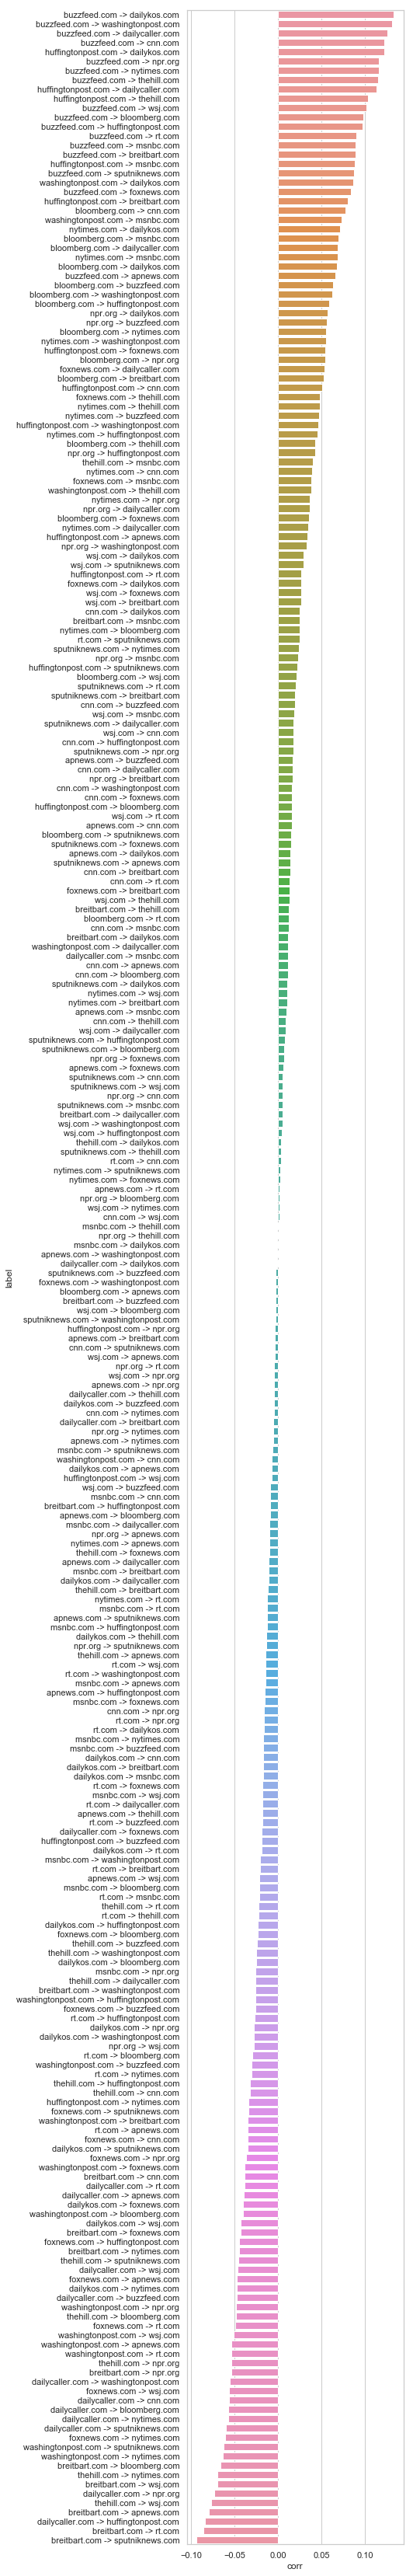

In [25]:
plt.figure(figsize=(5,60))
sns.barplot(x='corr', y='label', data=corr_df.sort_values('corr', ascending=False))

buzzfeed.com dailykos.com


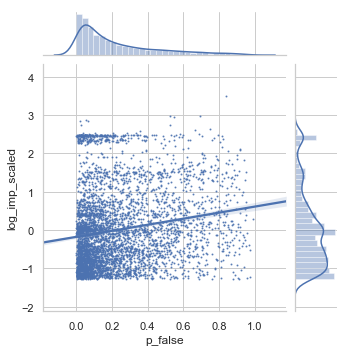

buzzfeed.com washingtonpost.com


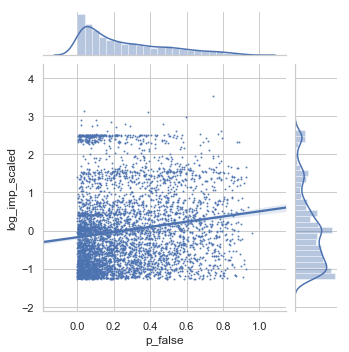

buzzfeed.com dailycaller.com


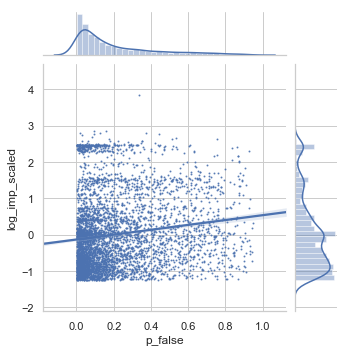

buzzfeed.com cnn.com


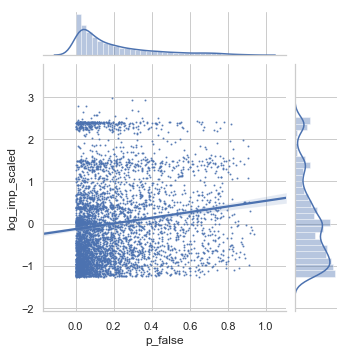

huffingtonpost.com dailykos.com


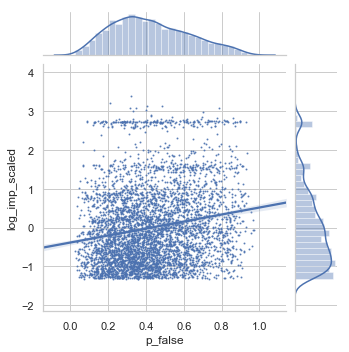

buzzfeed.com npr.org


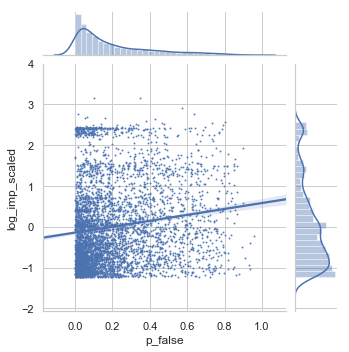

buzzfeed.com nytimes.com


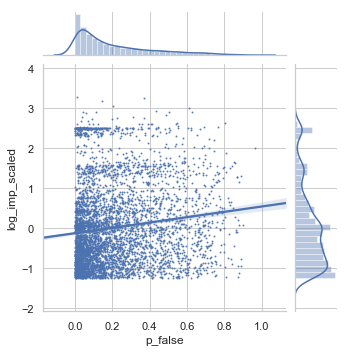

buzzfeed.com thehill.com


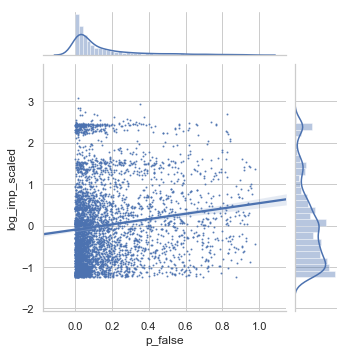

huffingtonpost.com dailycaller.com


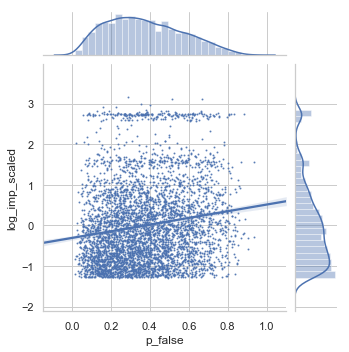

huffingtonpost.com thehill.com


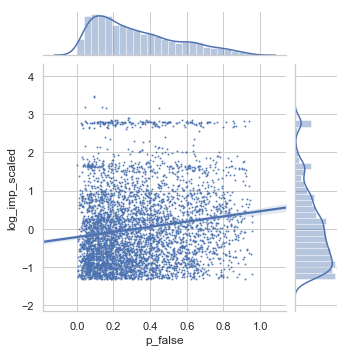

In [26]:
for r in corr_df.sort_values('corr', ascending=False).head(10).itertuples():
    print(r.d1, r.d2)
    sl_imp_corr(r.d1, r.d2, True)

breitbart.com sputniknews.com


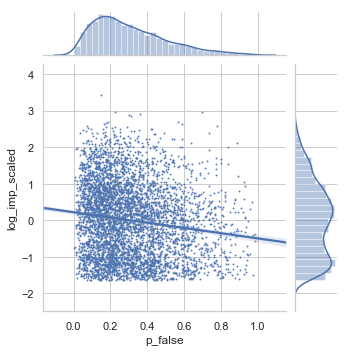

breitbart.com rt.com


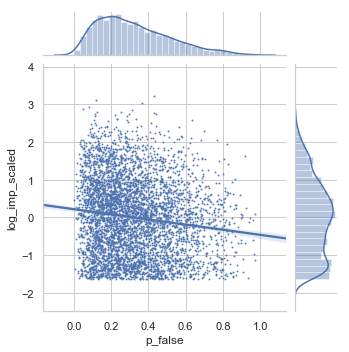

dailycaller.com huffingtonpost.com


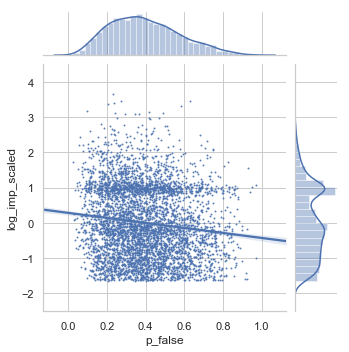

breitbart.com apnews.com


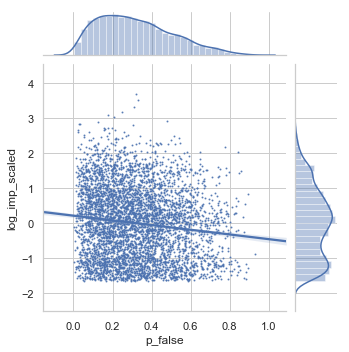

thehill.com wsj.com


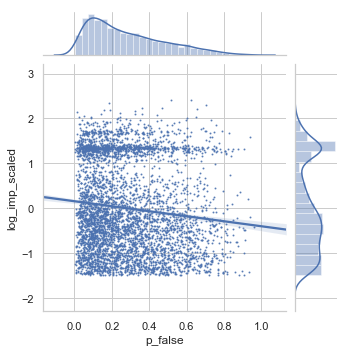

dailycaller.com npr.org


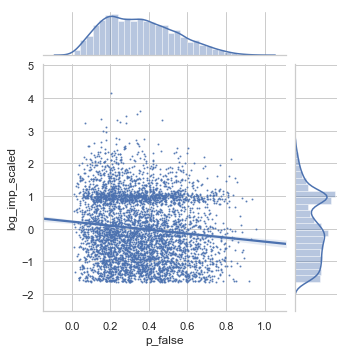

breitbart.com wsj.com


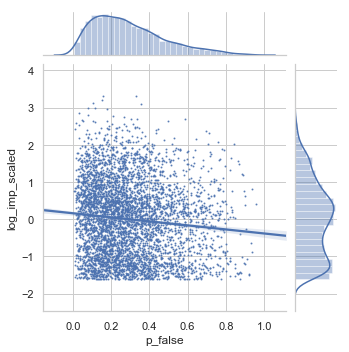

thehill.com nytimes.com


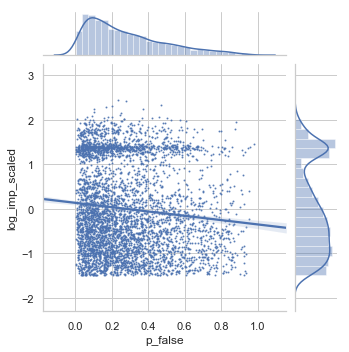

breitbart.com bloomberg.com


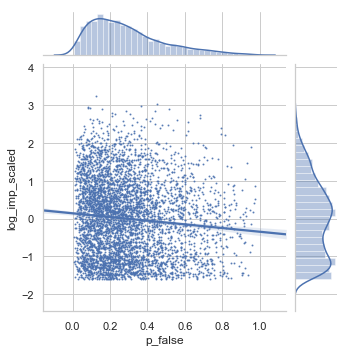

washingtonpost.com nytimes.com


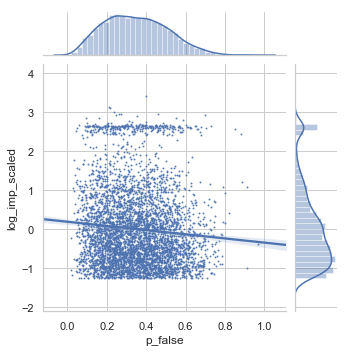

In [27]:
for r in corr_df.sort_values('corr', ascending=True).head(10).itertuples():
    print(r.d1, r.d2)
    sl_imp_corr(r.d1, r.d2, True)

On average, moving towards DK correlates most with impressions.

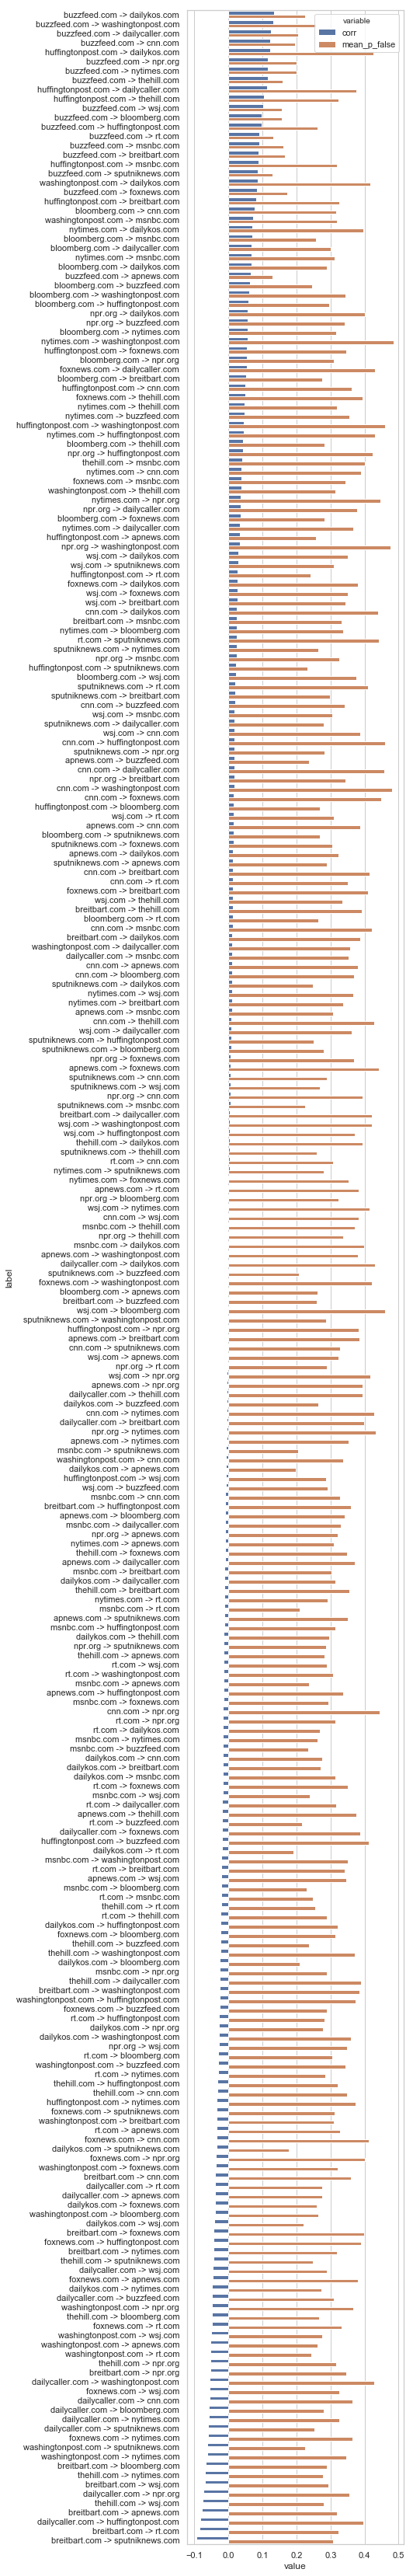

In [29]:
mdf = corr_df.melt(['d1', 'd2', 'label'], ['corr', 'mean_p_false'])
order = mdf[mdf.variable=='corr'].sort_values('value', ascending=False).label
plt.figure(figsize=(5,60))
sns.barplot(x='value', y='label', data=mdf, hue='variable', order=order)

In [30]:
stats.kendalltau(corr_df['corr'], corr_df.mean_p_false)

KendalltauResult(correlation=0.037171695246364225, pvalue=0.3608767984221851)

## Without HuffPo and Buzzfeed in d1->__

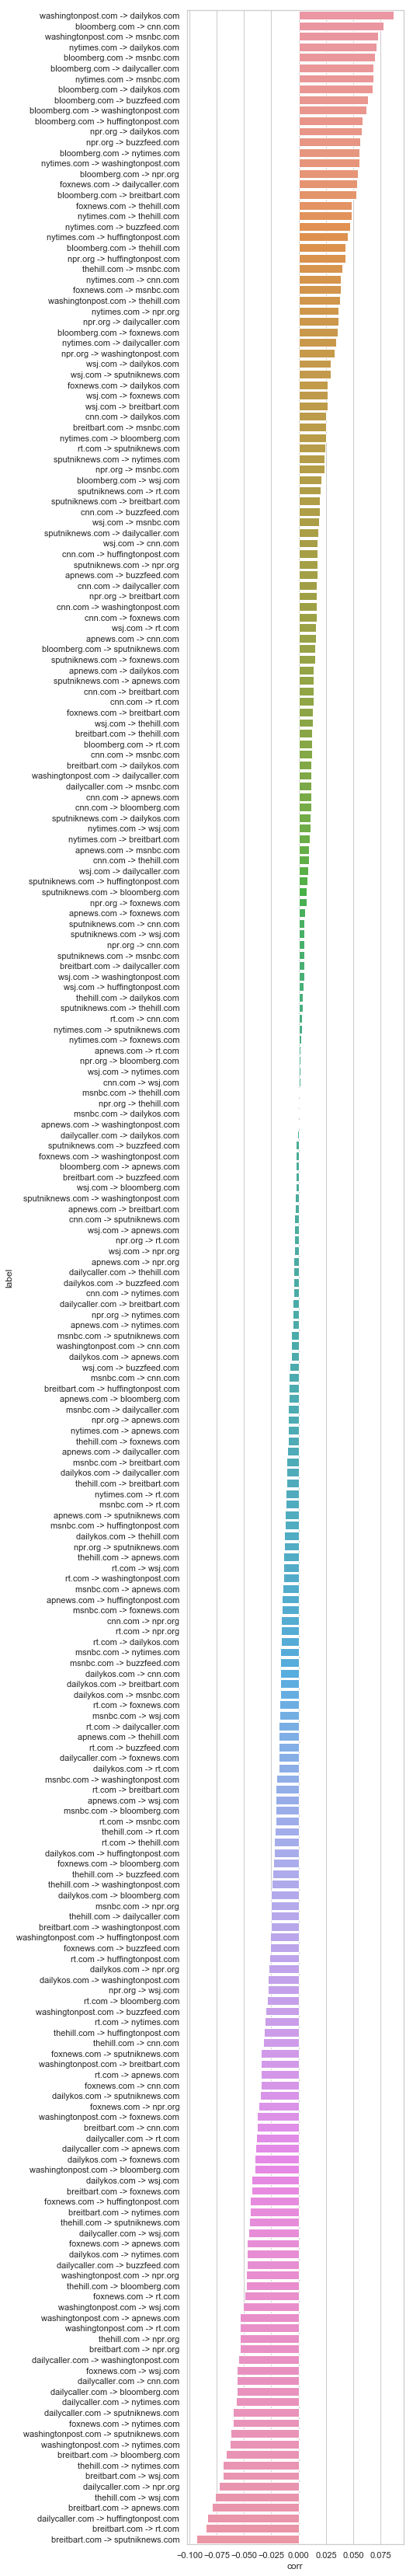

In [65]:
plt.figure(figsize=(5,60))

sns.barplot(
    x='corr',
    y='label',
    data=corr_df[~corr_df.d1.isin(['huffingtonpost.com', 'buzzfeed.com'])].sort_values('corr', ascending=False),
)

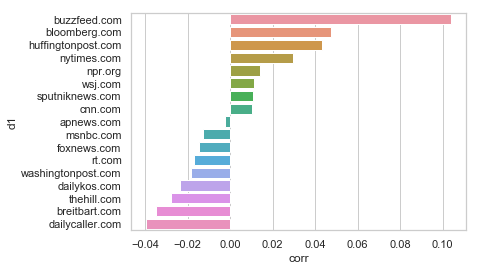

In [64]:
sns.barplot(
    x='corr',
    y='d1',
    data=corr_df.groupby('d1').mean().sort_values('corr', ascending=False).reset_index(),
)

- Least optimized / largest reward for sounding like other outlets - BuzzFeed, Bloomberg, HuffPo, NYT. (All left-leaning or financial.)
- Most optimized / largest penalty for sounding like other outlets - DC, Breitbart, Hill (partisan-right), DK, WaPo (partisan-left).

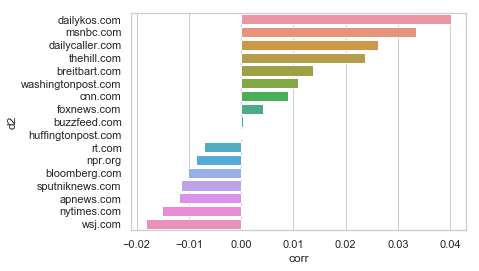

In [66]:
sns.barplot(
    x='corr',
    y='d2',
    data=corr_df.groupby('d2').mean().sort_values('corr', ascending=False).reset_index(),
)

- Most successful content signatures - DK, MSNBC, DC, Hill
- Least successful content signatures - WSJ, NYT, AP

- When right-leaning outlets sound like left-leaning / centrist outlets, correlates with fewer impressions. Right-leaning outlets penalized for moving out of their "lanes."
- All of the strongest individual positive correlations are HuffPo or Buzzfeed moving towards politically oriented outlets; presumably moving away from "listicle"-esque content, which seems to correlate with low impressions.
- In a sense, though, this listicle->politics axis is somewhat of a one-off phenomenon. If we remove pairs with HuffPo / Buzzfeed in the anchor position, then the strongest positive correlations are mostly cases of "centrist" outlets moving towards more partisan outlets - and largely among pairs that are both left-learning - that is, center-left moving towards far-left. Eg, WaPo -> DailyKos, WaPo -> MSNBC, NYT -> DailyKos.
- So - right-leaning outlets like Breitbart, DC, The Hill have the most "rigid" content identities. When they sound less like themselves and more like other outlets, they see the strongest falloffs in reach. Followed by DailyKos and WaPo on the left.